# Script

In [280]:
import numpy as np
import scipy.stats as stats


class lr:

    def __init__(self):
        self._d = None
        self._n = None
        self._con_lvl = 0.95
        self.a = 1-self._con_lvl    # alpha
        self.b = None

    @property
    def d(self):
        return self._d
    
    @property
    def n(self):
        return self._n

    @property
    def confidence_level(self):
        return self._con_lvl

    def fit(self, X, y):
        self.b = np.linalg.pinv(X.T @ X) @ X.T @ y
        self._d = len(self.b) - 1
        self._n = y.shape[0]

    def predict(self, X):
        return X @ self.b

    def variance(self, X, y):
        SSE = np.sum(np.square(y - X @ self.b))
        return SSE / (self._n - self._d - 1)

    def standard_deviation(self, X, y):
        var = self.variance(X, y)
        return np.sqrt(var)

    def significance(self, X, y):
        var = self.variance(X, y)
        std_dev = np.sqrt(var)
        SSE = np.sum(np.square(y - X @ self.b))
        SST = np.sum(np.square(y - np.mean(y)))
        SSR = SST - SSE
        f_stat = (SSR / self._d) / var
        f_pvalue = stats.f.sf(f_stat, self._d, self._n - self._d - 1)
        cov_matrix = np.linalg.pinv(X.T @ X) * var
        ti_stat = [self.b[i] / (std_dev * np.sqrt(cov_matrix[i, i])) for i in range(self._d)]
        ti_pvalues = [2 * min(stats.t.cdf(i, self._n - self._d - 1), stats.t.sf(i, self._n - self._d - 1)) for i in ti_stat]
        return {
            "f_pvalue": f_pvalue, 
            "ti_pvalues": ti_pvalues
        }

    def r_squared(self, X, y):
        SSE = np.sum(np.square(y - X @ self.b))
        SST = np.sum(np.square(y - np.mean(y)))
        SSR = SST - SSE
        return SSR / SST
    
    def test_relevance(self, X, y):
        SSE = np.sum(np.square(y - X @ self.b))
        RSE = np.sqrt(SSE / (self._n - 2))
        MSE = (1 / self._n) * SSE
        RMSE = np.sqrt(MSE)
        return {
            "RSE": RSE,
            "MSE": MSE, 
            "RMSE": RMSE
        }

    def pearson(self, X):
        return np.corrcoef(X, rowvar=False) # RuntimeWarning: invalid value encountered in divide c /= stddev[:, None]
    
    def confidence_intervals(self, X, y):
        var = self.variance(X, y)
        std_dev = self.standard_deviation(X, y)
        cov_matrix = np.linalg.pinv(X.T @ X) * var
        t_crit = stats.t.ppf(1 - self.a / 2, self._n - self._d - 1)
        ci = []
        for i in range(self._d + 1):
            std_err = std_dev * np.sqrt(cov_matrix[i,i])
            margin = t_crit * std_err
            lower = self.b[i] - margin
            upper = self.b[i] + margin
            ci.append((lower, upper))
        return ci

# Analysis

## Dependencies and data standardisation

In [281]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
# from linear_regression import LinearRegression as lr

data = pd.read_csv("../data/Small-diameter-flow.csv", index_col=0)
data_std = data.copy()
for column in ["Flow", "Kinematic", "Geometric", "Inertial"]:
    mean = np.mean(data[column])
    sample_std_dev = np.std(data[column], ddof=1) # since this is not the population
    data_std[column] = (data[column] - mean) / sample_std_dev

## Testing for observer bias

In [282]:
# use the whole data set
# run tests
# print results
# decide whether to include or exclude observer column

In [283]:
bias_df = data_std[["Flow", "Observer"]]
X_bias = np.column_stack([np.ones(len(bias_df)), bias_df["Observer"]])
y_bias = bias_df["Flow"]

bias = lr()
bias.fit(X_bias, y_bias)
bias_pvalue = bias.significance(X_bias, y_bias)
ci_bias = bias.confidence_intervals(X_bias, y_bias)
r_bias = bias.pearson(bias_df)
R2_bias = bias.r_squared(X_bias, y_bias)

print(f"Significance of f-statistic: {bias_pvalue['f_pvalue']:.4f}")
print(f"Significance of t-statistic: {bias_pvalue['ti_pvalues'][0]:.4f}")
print()
print("Confidence intervals for each coefficient ...")
for i, (lower, upper) in enumerate(ci_bias):
    print(f"... β{i}: {bias.b[i]:.4f} ± {upper - lower:.4f}")
print()
print(f"Correlation: {r_bias[0, 1]:.4f}")
print()
print(f"R²: {R2_bias:.4f}")

Significance of f-statistic: 0.0105
Significance of t-statistic: 0.0839

Confidence intervals for each coefficient ...
... β0: -0.1603 ± 0.5545
... β1: 0.3648 ± 0.8366

Correlation: 0.1815

R²: 0.0329


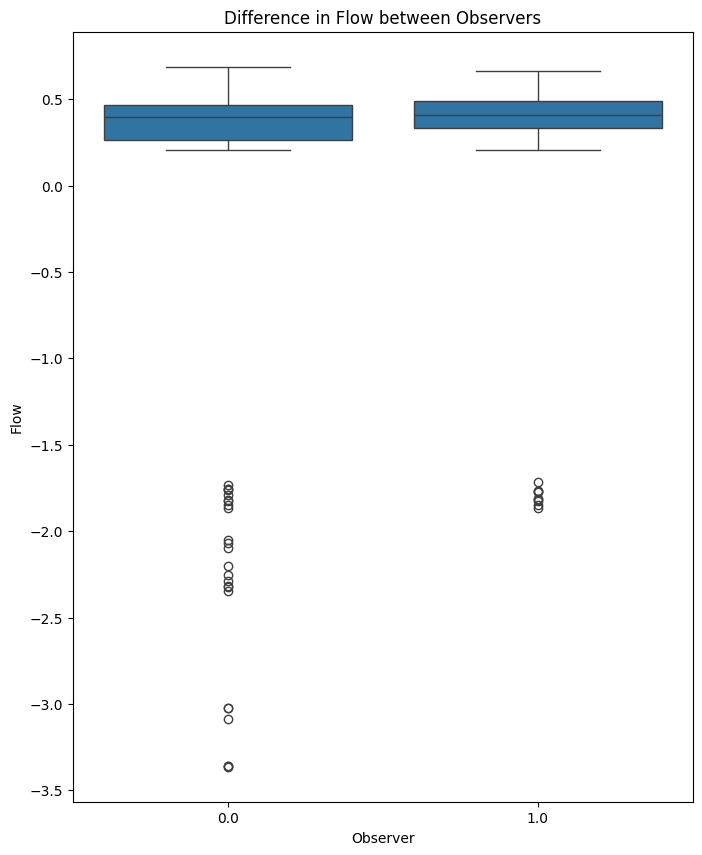

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 10))
sns.boxplot(x="Observer", y="Flow", data=data_std)
plt.title("Difference in Flow between Observers")
plt.xlabel("Observer")
plt.ylabel("Flow")
plt.show()

In [285]:
# In numbers, showing that Observer 1 records higher flow values
temp = data_std[["Flow", "Observer"]].copy()
zero_mean = np.mean(temp[temp["Observer"] == 0]["Flow"])
one_mean = np.mean(temp[temp["Observer"] == 1]["Flow"])
print(zero_mean, one_mean)

-0.16026957952930065 0.20448187733048656


## Creating prediction sets

In [286]:
data_shuffled = data_std.sample(frac=1, random_state=42)  # setting the seed for reproducibility

train_indices = round(0.8 * len(data_shuffled))
val_indices = round(0.25 * train_indices)
test_indices = round(0.2 * len(data_shuffled))

test_df = pd.DataFrame(data_shuffled[:test_indices])
train_df = pd.DataFrame(data_shuffled[test_indices:])
val_df = pd.DataFrame(train_df[:val_indices])
train_df = pd.DataFrame(train_df[val_indices:])

X_train = np.column_stack([np.ones(len(train_df)), train_df["Kinematic"], train_df["Geometric"], train_df["Inertial"], train_df["Observer"]])
y_train = train_df["Flow"]

X_val = np.column_stack([np.ones(len(val_df)), val_df["Kinematic"], val_df["Geometric"], val_df["Inertial"], val_df["Observer"]])
y_val = val_df["Flow"]

X_test = np.column_stack([np.ones(len(test_df)), test_df["Kinematic"], test_df["Geometric"], test_df["Inertial"], test_df["Observer"]])
y_test = test_df["Flow"]

## Running the model and printing outputs

In [287]:
model = lr()
model.fit(X_train, y_train)
predictions = model.predict(X_val)

print(f"Number of features: {model.d}")
print(f"Number of rows: {model.n}") # from X_train
print()
print(f"Variance: {model.variance(X_train, y_train):.2e}")
print(f"Standard deviation: {model.standard_deviation(X_train, y_train):.2e}")
print()
sig = model.significance(X_train, y_train) # returns dictionary with f_pvalue and ti_pvalues
print(f"Significance of f-statistic: {sig["f_pvalue"]:.2e}")
print(f"Significance of t-statistic for ...\n... Kinematic: {sig["ti_pvalues"][0]:.2e}\n... Geometric: {sig["ti_pvalues"][1]:.2e}\n... Inertial:  {sig["ti_pvalues"][2]:.2e}")
print()
print(f"Relevance (R²): {model.r_squared(X_train, y_train):.2e}")
print()
t_rel = model.test_relevance(X_train, y_train) # returns dictionary with RSE, MSE and RMSE
t_r2 = model.r_squared(X_train, y_train)
v_rel = model.test_relevance(X_val, y_val)
v_r2 = model.r_squared(X_val, y_val)
t_rel = {key: value.item() for key, value in t_rel.items()}
v_rel = {key: value.item() for key, value in v_rel.items()}
print(f"Training relevance ...\n... RSE:  {t_rel["RSE"]:.2e}\n... MSE:  {t_rel["MSE"]:.2e}\n... RMSE: {t_rel["RMSE"]:.2e}")
print()
print(f"Validation relevance ...\n... RSE:  {v_rel["RSE"]:.2e}\n... MSE:  {v_rel["MSE"]:.2e}\n... RMSE: {v_rel["RMSE"]:.2e}")
print()
r = model.pearson(X_train) # returns a correlation matrix
cols = ["Intercept", "Kinematic", "Geometric", "Inertial", "Observer"]
print(f"Correlation pairs ...")
for i in range(len(cols)):
    if i == 0:
        continue
    else:
        for j in range(i + 1, len(cols)):
            print(f"... {cols[i]} - {cols[j]}: {r[i, j]:.4f}")
print()
ci = model.confidence_intervals(X_train, y_train) # returns the confidence intervals for all parameters
print("Confidence intervals for each coefficient ...")
for i, (lower, upper) in enumerate(ci):
    print(f"... β{i}: {model.b[i]:.4f} ± {upper - lower:.4f}")

Number of features: 4
Number of rows: 118

Variance: 2.96e-03
Standard deviation: 5.44e-02

Significance of f-statistic: 3.93e-143
Significance of t-statistic for ...
... Kinematic: 1.75e-75
... Geometric: 3.60e-157
... Inertial:  2.06e-245

Relevance (R²): 9.97e-01

Training relevance ...
... RSE:  5.37e-02
... MSE:  2.84e-03
... RMSE: 5.32e-02

Validation relevance ...
... RSE:  3.19e-02
... MSE:  9.99e-04
... RMSE: 3.16e-02

Correlation pairs ...
... Kinematic - Geometric: 0.8688
... Kinematic - Inertial: 0.9720
... Kinematic - Observer: 0.1783
... Geometric - Inertial: 0.9196
... Geometric - Observer: 0.2242
... Inertial - Observer: 0.1774

Confidence intervals for each coefficient ...
... β0: -0.0175 ± 0.0023
... β1: 0.2968 ± 0.0072
... β2: 1.1006 ± 0.0044
... β3: -0.3989 ± 0.0090
... β4: 0.0191 ± 0.0034


/home/albot/coding/repos/stat_met/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/albot/coding/repos/stat_met/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# To do

In [288]:
# kolla signifikansen på båda observers för sista VG-frågan
# extras

# Test